# Import modules

Firstly, let's import the modules that we will use in this example

In [2]:
import xarray as xr # For creating a NetCDF dataset
import pandas as pd # For reading in data (CSV, xlsx etc) to a dataframe
from datetime import datetime as dt # Handling dates and times
import uuid # Creating a UUID for the dataset

# Loading and checking the data

Let's look at the data we are working with first

In [3]:
data = pd.read_excel('chlorophyll_a_depth_profile_variables.xlsx', sheet_name='Data')
data

,eventID,parentEventID,eventTime,stationName,decimalLatitude,decimalLongitude,bottomDepthInMeters,sampleDepthInMeters,mass_concentration_of_chlorophyll_a_in_sea_water
0,fe94bd44-dfbb-11eb-ba80-0242ac130004,fe94e17a-dfbb-11eb-ba80-0242ac130004,2019-04-18T09:30:12Z,P1 (NLEG01),75.99995,31.219677,325.05,10,0.336496
1,fe94bfe2-dfbb-11eb-ba80-0242ac130004,fe94e17a-dfbb-11eb-ba80-0242ac130004,2019-04-18T09:30:12Z,P1 (NLEG01),75.99995,31.219677,325.05,20,0.410839
2,fe94c0dc-dfbb-11eb-ba80-0242ac130004,fe94e17a-dfbb-11eb-ba80-0242ac130004,2019-04-18T09:30:12Z,P1 (NLEG01),75.99995,31.219677,325.05,30,0.316933
3,fe94c2da-dfbb-11eb-ba80-0242ac130004,fe94e17a-dfbb-11eb-ba80-0242ac130004,2019-04-18T09:30:12Z,P1 (NLEG01),75.99995,31.219677,325.05,40,0.385015
4,fe94c3ac-dfbb-11eb-ba80-0242ac130004,fe94e17a-dfbb-11eb-ba80-0242ac130004,2019-04-18T09:30:12Z,P1 (NLEG01),75.99995,31.219677,325.05,50,0.990708
5,fe94c46a-dfbb-11eb-ba80-0242ac130004,fe94e17a-dfbb-11eb-ba80-0242ac130004,2019-04-18T09:30:12Z,P1 (NLEG01),75.99995,31.219677,325.05,60,0.221853
6,fe94c5be-dfbb-11eb-ba80-0242ac130004,fe94e17a-dfbb-11eb-ba80-0242ac130004,2019-04-18T09:30:12Z,P1 (NLEG01),75.99995,31.219677,325.05,90,0.030989
7,fe94c67c-dfbb-11eb-ba80-0242ac130004,fe94e17a-dfbb-11eb-ba80-0242ac130004,2019-04-18T09:30:12Z,P1 (NLEG01),75.99995,31.219677,325.05,120,0.016551
8,fe94c7d0-dfbb-11eb-ba80-0242ac130004,fe94e17a-dfbb-11eb-ba80-0242ac130004,2019-04-18T09:30:12Z,P1 (NLEG01),75.99995,31.219677,325.05,200,0.025120
9,fe94c88e-dfbb-11eb-ba80-0242ac130004,fe94e17a-dfbb-11eb-ba80-0242ac130004,2019-04-18T09:30:12Z,P1 (NLEG01),75.99995,31.219677,325.05,315,0.038736


We have a depth profile of Chlorophyll A data from a single station. Most of the column headers are taken from the spreadsheet templates generators that were used to log the metadata. 

https://www.sios-svalbard.org/cgi-bin/darwinsheet/?setup=aen

Other columns headers, for the data, are taken from the CF standard names. This is a controlled vocabulary, where parameter names can be searched for online, with descriptions, so that everyone is clear what the data represent. 

http://cfconventions.org/standard-names.html

<AxesSubplot:xlabel='sampleDepthInMeters'>

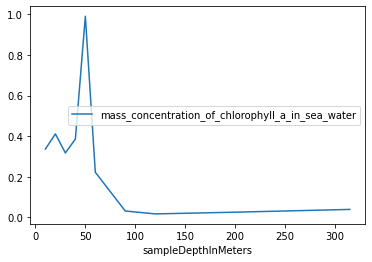

In [4]:
data.plot(x='sampleDepthInMeters', y='mass_concentration_of_chlorophyll_a_in_sea_water')

# Creating an xarray dataset

With xarray, it is easy to create an xarray dataset and convert it to a NetCDF dataset.

We can write the variables that vary within a single dataset to an xarray dataset. In this case, this is the depth, eventID and the chlorophyll a variable. Note that we are not storing the parentEventID column here. This parent/child relationship will be maintained in the metadata catalogue below. This metadata catalogue can be referred to and includes supplementary metadata that we don't want to include in the published dataset.

https://sios-svalbard.org/aen/tools

In [6]:
# Note the double square brackets
xrds = xr.Dataset.from_dataframe(data[['sampleDepthInMeters','eventID','mass_concentration_of_chlorophyll_a_in_sea_water']]) 

# Dimensions

A NetCDF file has dimensions that define the shape of the data. In this case, our only dimension is the sample depth, and we have 10 depths for each station. 'depth' is a commonly defined dimension name, so to be CF-compliant, let's rename our sample depth.

In [7]:
xrds = xrds.rename_dims({'index':'depth'}) # Renaming dimension 'index' to 'depth'

# Renaming coordinate variable 'sampleDepthInMeters' to 'depth' to match dimension and be CF compliant.
xrds = xrds.rename({'sampleDepthInMeters':'depth'}) 
        
xrds = xrds.set_coords('depth') # Specfiy depth as a coordinate (to be used as a dimension)
        
xrds = xrds.reset_index('index', drop=True) # Get rid of the numeric index as dimension.

# Global attributes

Global attributes describe the dataset as a whole. A list of what global attributes must be included can be found here:

https://adc.met.no/node/4

These are based on the ACDD conventions, that you can find here:

https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_1-3

We refer to which conventions the file adheres to (including version) in the 'conventions' global attribute.

Additional global attributes can also be included, defined by the user. Make sure that the attribute names you select are understandable.

To save you from having to write them all out, I have written them in a separate file that you can load in as below.

In [9]:
global_attributes = pd.read_excel('chlorophyll_a_depth_profile_global_attributes.xlsx', index_col=0)

global_attributes

,Content
Attribute name,
title,Chlorophyll A measurements from the P1 (NLEG01...
naming_authority,University Centre in Svalbard (UNIS)
id,c4a1108a-2683-425d-9ad1-f23fd79e5224
summary,ANALAGOUS TO AN ABSTRACT IN A PAPER
keywords,Oceans > Ocean Chemistry > Chlorophyll
keywords_vocabulary,GCMD
geospatial_lat_min,76
geospatial_lat_max,76
geospatial_lon_min,31.2197


Let's flip the columns and rows the other way round

In [10]:
global_attributes_transposed = global_attributes.transpose()
global_attributes_transposed

Attribute name,title,naming_authority,id,summary,keywords,keywords_vocabulary,geospatial_lat_min,geospatial_lat_max,geospatial_lon_min,geospatial_lon_max,...,creator_url,creator_name,publisher_name,publisher_url,publisher_email,publisher_type,project,license,metadata_link,acknowledgements
Content,Chlorophyll A measurements from the P1 (NLEG01...,University Centre in Svalbard (UNIS),c4a1108a-2683-425d-9ad1-f23fd79e5224,ANALAGOUS TO AN ABSTRACT IN A PAPER,Oceans > Ocean Chemistry > Chlorophyll,GCMD,76,76,31.2197,31.2197,...,https://www.unis.no/staff/ola-nordmann/,Ola Nordmann,NIRD Research Data Archive,https://archive.norstore.no/,archive.manager@norstore.no,institution,The Nansen Legacy (RCN # 276730),https://creativecommons.org/licenses/by/4.0/,DOI PROVIDED BY DATA CENTRE – THAT LINKS TO TH...,Funded by the Research Council of Norway. John...


Now we can convert our dataframe to a dictionary that we can easily write to the xarray dataset (that will become our NetCDF file)

In [11]:
global_attributes_dic = global_attributes_transposed.to_dict('records')[0]
xrds.attrs=global_attributes_dic
xrds.attrs

{'title': 'Chlorophyll A measurements from the P1 (NLEG01) station in the Northern Barents Sea',
 'naming_authority': 'University Centre in Svalbard (UNIS)',
 'id': 'c4a1108a-2683-425d-9ad1-f23fd79e5224',
 'summary': 'ANALAGOUS TO AN ABSTRACT IN A PAPER',
 'keywords': 'Oceans > Ocean Chemistry > Chlorophyll',
 'keywords_vocabulary': 'GCMD',
 'geospatial_lat_min': 76,
 'geospatial_lat_max': 76,
 'geospatial_lon_min': 31.2197,
 'geospatial_lon_max': 31.2197,
 'time_coverage_start': '2019-04-18T09:30:12Z',
 'time_coverage_end': '2019-04-18T09:30:12Z',
 'Conventions': 'ACDD-1.3; CF-1.8',
 'history': 'File created using Python’s xarray at INSERT TIMESTAMP HERE',
 'source': 'Chlorophyll A from water sample from CTD with Niskin bottles',
 'processing_level': 'Acid correction applied to Chlorophyll A variable',
 'date_created': 'INSERT TIMESTAMP HERE',
 'creator_type': 'person',
 'creator_institution': 'The University Centre in Svalbard',
 'creator_email': 'olan@unis.no',
 'creator_url': 'http

In [27]:
xrds.attrs['date_created'] = dt.now().strftime("%Y-%m-%dT%H:%M:%SZ")
xrds.attrs['history'] = f'File create at {dt.now().strftime("%Y-%m-%dT%H:%M:%SZ")} using xarray in Python'
xrds.attrs

{'title': 'Chlorophyll A measurements from the P1 (NLEG01) station in the Northern Barents Sea',
 'naming_authority': 'University Centre in Svalbard (UNIS)',
 'id': 'c4a1108a-2683-425d-9ad1-f23fd79e5224',
 'summary': 'ANALAGOUS TO AN ABSTRACT IN A PAPER',
 'keywords': 'Oceans > Ocean Chemistry > Chlorophyll',
 'keywords_vocabulary': 'GCMD',
 'geospatial_lat_min': 76,
 'geospatial_lat_max': 76,
 'geospatial_lon_min': 31.2197,
 'geospatial_lon_max': 31.2197,
 'time_coverage_start': '2019-04-18T09:30:12Z',
 'time_coverage_end': '2019-04-18T09:30:12Z',
 'Conventions': 'ACDD-1.3; CF-1.8',
 'history': 'File create at 2022-01-28T09:34:25Z using xarray in Python',
 'source': 'Chlorophyll A from water sample from CTD with Niskin bottles',
 'processing_level': 'Acid correction applied to Chlorophyll A variable',
 'date_created': '2022-01-28T09:34:25Z',
 'creator_type': 'person',
 'creator_institution': 'The University Centre in Svalbard',
 'creator_email': 'olan@unis.no',
 'creator_url': 'https:

# Variable attributes

Variable attributes describe each variable. Let's add some attributes for our variables.

The *standard_name* should be selected from here: http://cfconventions.org/standard-names.html. Standard names are commonly accepted parameter names with descriptions. By selecting appropriate standard names for your variable, the data user will be clear exactly what the data represent.

The *units* should match what is provided for the standard name as listed above. You may need to convert your data.

The *long_name* is more descriptive and can be in your own words.

The *coverage_content_type* describes what type of data the variable contains

Some help on these variable attributes can be found here: https://commons.esipfed.org/acdd_1-3_references

In [12]:
xrds['mass_concentration_of_chlorophyll_a_in_sea_water'].attrs = {
'standard_name':'mass_concentration_of_chlorophyll_a_in_sea_water',
'long_name':'Mass concentration of Chlorophyll A in sea water, after acid correction',
'units': 'kg m-3',
'coverage_content_type': 'physicalMeasurement'
}

# Add variable attributes
xrds['eventID'].attrs = {
# No standard name for eventID, but this is okay as it is not a measurement but reference to a sample
'long_name':'Univerisally unique identidication (UUID) of sample as provided in Nansen Legacy metadata catalogue on SIOS (https://sios-svalbard.org/aen/tools), where rich metadata are hosted for each sample',
'units': '',
'coverage_content_type': 'referenceInformation'
}

Ensure that data are written in the correct form to NetCDF. 
Data served through THREDDS Data Servers cannot have int64 datetime 
specifications, but int32. Also, encoding of missing values are done 
in this step along compression.

# Converting to NetCDF-CF

First, we specify the encoding, then we conver the data to a NetCDF file.

In [14]:
myencoding = {
            'depth': {
                'dtype': 'int32',
                '_FillValue': None # Coordinate variables should not have fill values.
            },
            'mass_concentration_of_chlorophyll_a_in_sea_water': {
                '_FillValue': -999.0,
                'zlib': False
            },
            # netCDF4 does not yet support setting a fill value for variable-length strings
            'eventID': { 
                'zlib': False,
            }
        }
        
xrds.to_netcdf(f'chlorophyll_a_depth_profile_variables.nc',encoding=myencoding)

And that is it! 

# QC the dataset

Now we can check that the file is okay by loading it in again.

In [15]:
myfile = xr.load_dataset(f'chlorophyll_a_depth_profile_variables.nc')

In [16]:
myfile

<xarray.Dataset>
Dimensions:                                           (depth: 10)
Coordinates:
  * depth                                             (depth) int32 10 ... 315
Data variables:
    eventID                                           (depth) object 'fe94bd4...
    mass_concentration_of_chlorophyll_a_in_sea_water  (depth) float64 0.3365 ...
Attributes: (12/30)
    title:                Chlorophyll A measurements from the P1 (NLEG01) sta...
    naming_authority:     University Centre in Svalbard (UNIS)
    id:                   c4a1108a-2683-425d-9ad1-f23fd79e5224
    summary:              ANALAGOUS TO AN ABSTRACT IN A PAPER
    keywords:             Oceans > Ocean Chemistry > Chlorophyll
    keywords_vocabulary:  GCMD
    ...                   ...
    publisher_email:      archive.manager@norstore.no
    publisher_type:       institution
    project:              The Nansen Legacy (RCN # 276730)
    license:              https://creativecommons.org/licenses/by/4.0/
    metadata_link:        DOI PROVIDED BY DATA CENTRE – THAT LINKS TO THE LAN...
    acknowledgements:     Funded by the Research Council of Norway. John Doe ...

In [17]:
myfile.attrs

{'title': 'Chlorophyll A measurements from the P1 (NLEG01) station in the Northern Barents Sea',
 'naming_authority': 'University Centre in Svalbard (UNIS)',
 'id': 'c4a1108a-2683-425d-9ad1-f23fd79e5224',
 'summary': 'ANALAGOUS TO AN ABSTRACT IN A PAPER',
 'keywords': 'Oceans > Ocean Chemistry > Chlorophyll',
 'keywords_vocabulary': 'GCMD',
 'geospatial_lat_min': 76,
 'geospatial_lat_max': 76,
 'geospatial_lon_min': 31.2197,
 'geospatial_lon_max': 31.2197,
 'time_coverage_start': '2019-04-18T09:30:12Z',
 'time_coverage_end': '2019-04-18T09:30:12Z',
 'Conventions': 'ACDD-1.3; CF-1.8',
 'history': 'File created using Python’s xarray at INSERT TIMESTAMP HERE',
 'source': 'Chlorophyll A from water sample from CTD with Niskin bottles',
 'processing_level': 'Acid correction applied to Chlorophyll A variable',
 'date_created': 'INSERT TIMESTAMP HERE',
 'creator_type': 'person',
 'creator_institution': 'The University Centre in Svalbard',
 'creator_email': 'olan@unis.no',
 'creator_url': 'http

In [18]:
myfile.data_vars

Data variables:
    eventID                                           (depth) object 'fe94bd4...
    mass_concentration_of_chlorophyll_a_in_sea_water  (depth) float64 0.3365 ...

In [19]:
myfile['mass_concentration_of_chlorophyll_a_in_sea_water']

<xarray.DataArray 'mass_concentration_of_chlorophyll_a_in_sea_water' (depth: 10)>
array([0.3364965 , 0.41083875, 0.31693275, 0.3850146 , 0.9907083 ,
       0.22185293, 0.03098898, 0.01655093, 0.02511985, 0.03873622])
Coordinates:
  * depth    (depth) int32 10 20 30 40 50 60 90 120 200 315
Attributes:
    standard_name:          mass_concentration_of_chlorophyll_a_in_sea_water
    long_name:              Mass concentration of Chlorophyll A in sea water,...
    units:                  kg m-3
    coverage_content_type:  physicalMeasurement

In [20]:
myfile['eventID']

<xarray.DataArray 'eventID' (depth: 10)>
array(['fe94bd44-dfbb-11eb-ba80-0242ac130004',
       'fe94bfe2-dfbb-11eb-ba80-0242ac130004',
       'fe94c0dc-dfbb-11eb-ba80-0242ac130004',
       'fe94c2da-dfbb-11eb-ba80-0242ac130004',
       'fe94c3ac-dfbb-11eb-ba80-0242ac130004',
       'fe94c46a-dfbb-11eb-ba80-0242ac130004',
       'fe94c5be-dfbb-11eb-ba80-0242ac130004',
       'fe94c67c-dfbb-11eb-ba80-0242ac130004',
       'fe94c7d0-dfbb-11eb-ba80-0242ac130004',
       'fe94c88e-dfbb-11eb-ba80-0242ac130004'], dtype=object)
Coordinates:
  * depth    (depth) int32 10 20 30 40 50 60 90 120 200 315
Attributes:
    long_name:              Univerisally unique identidication (UUID) of samp...
    units:                  
    coverage_content_type:  referenceInformation

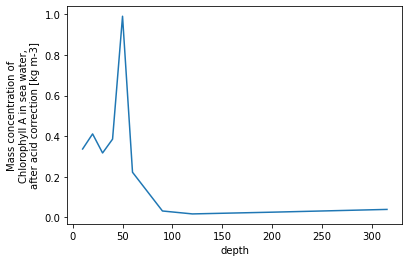

In [21]:
myfile['mass_concentration_of_chlorophyll_a_in_sea_water'].plot.line()